IMPORTING LIBRARIES

In [1]:
import yfinance as yf
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FETCHING DATA

In [2]:
ticker = 'JPM'
df = yf.download(tickers = ticker, start = '2020-01-01',auto_adjust = True).dropna()

[*********************100%***********************]  1 of 1 completed


DEFINING SIGNAL

In [3]:
df['long_ma'] = df['Close'].rolling(200).mean()
df['short_ma'] = df['Close'].rolling(50).mean()

In [4]:
df['Signal'] = np.where(df['short_ma'] > df['long_ma'],1,-1)

In [5]:
df['Position'] = df['Signal'].shift(1)
df['Trade'] = df['Position'].diff().abs()
df = df.dropna().copy()
cost = 0.001
INCLUDE_COST = True

In [6]:
#Deleting NA data for cleaner plot
df = df.dropna()

PLOTTING THE STRATEGY

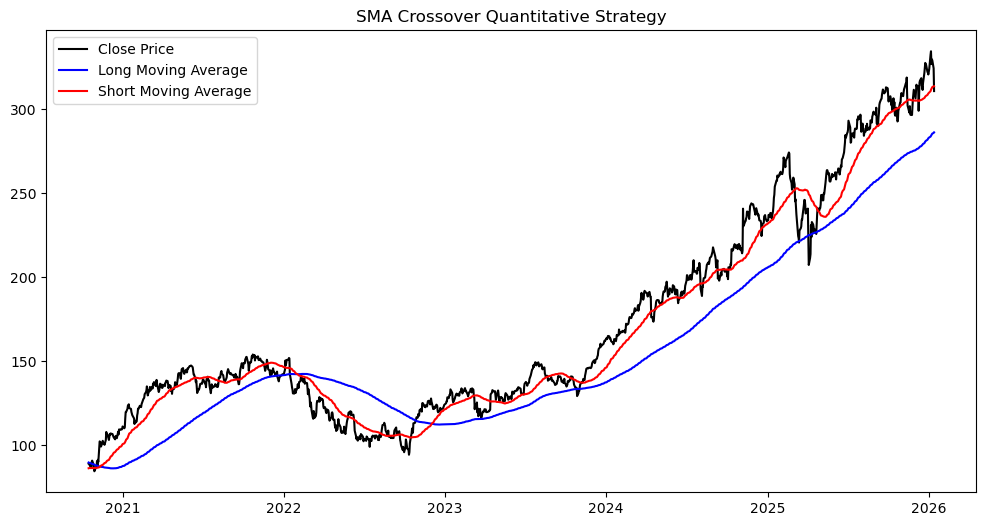

In [7]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close Price', color='black', alpha = 1)
plt.plot(df['long_ma'], label='Long Moving Average', color='blue', alpha = 1)
plt.plot(df['short_ma'],label='Short Moving Average',color='red' , alpha = 1)


plt.title('SMA Crossover Quantitative Strategy')
plt.legend()
plt.show()

BACKTESTING RETURNS

In [8]:
df['Returns'] = np.log(df['Close']/df['Close'].shift(1))
df = df.dropna().copy()
df['Cost'] = df['Trade'] * np.log(1 - cost)
df = df.dropna().copy()
if INCLUDE_COST:
    df['Strategy_returns'] = df['Position'] * df['Returns'] - df['Cost']
    df = df.dropna().copy()
else:
    df['Strategy_returns'] = df['Position'] * df['Returns']
    df = df.dropna().copy()

EQUITY CURVE

In [9]:
df['Cum_Market'] = np.exp(df['Returns'].cumsum())
df['Cum_Strategy'] = np.exp(df['Strategy_returns'].cumsum())

In [10]:
assert(df[['Cum_Market', 'Cum_Strategy']] > 0).all().all()

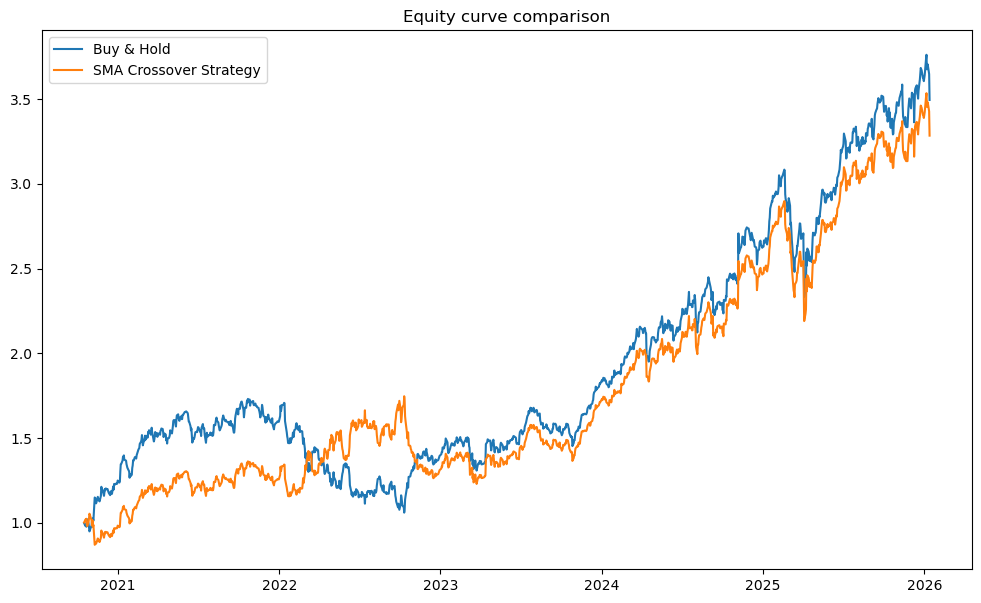

In [11]:
# Plotting equity curve

plt.figure(figsize=(12,7))
plt.plot(df['Cum_Market'] ,label = 'Buy & Hold')
plt.plot(df['Cum_Strategy'] ,label = 'SMA Crossover Strategy')
plt.legend()
plt.title('Equity curve comparison')
plt.show()

PERFORMANCE METRICS

In [12]:
# Assuming annual risk free rate to be 3%
annual_rf = 0.03

# Calculating excess returns
daily_rf = (1 + annual_rf)**(1/252) - 1
df['Excess_returns'] = df['Strategy_returns'] - daily_rf

#Sharp Ratio
sharpe_ratio = (df['Excess_returns'].mean())/(df['Excess_returns'].std() * np.sqrt(252))

# Down side deviation
target = 0.0
df['Downside'] = np.minimum(df['Strategy_returns'] - target, 0)
downside_std = np.sqrt((df['Downside']**2).mean())

# Sortino
sortino_ratio = (df['Excess_returns'].mean())/(downside_std*np.sqrt(252))

In [13]:
print('Sharpe Ratio : ',sharpe_ratio)
print('Sortino Ratio : ',sortino_ratio)

Sharpe Ratio :  0.0031332220406404517
Sortino Ratio :  0.00433853540470642


In [14]:
df['Relative_Equity'] = df['Cum_Strategy'] / df['Cum_Market']

In [15]:
def drawdown(equity):
    running_max = equity.cummax()
    return equity / running_max - 1

In [16]:
df['Draw_down_buy&hold'] = drawdown(df['Cum_Market'])
df['Draw_down_Strategy'] = drawdown(df['Cum_Strategy'])

In [17]:
max_dd_bh = df['Draw_down_buy&hold'].min()
max_dd_strategy = df['Draw_down_Strategy'].min()

In [18]:
max_dd_bh

-0.3877157305973147

In [19]:
max_dd_strategy

-0.2962864596468503

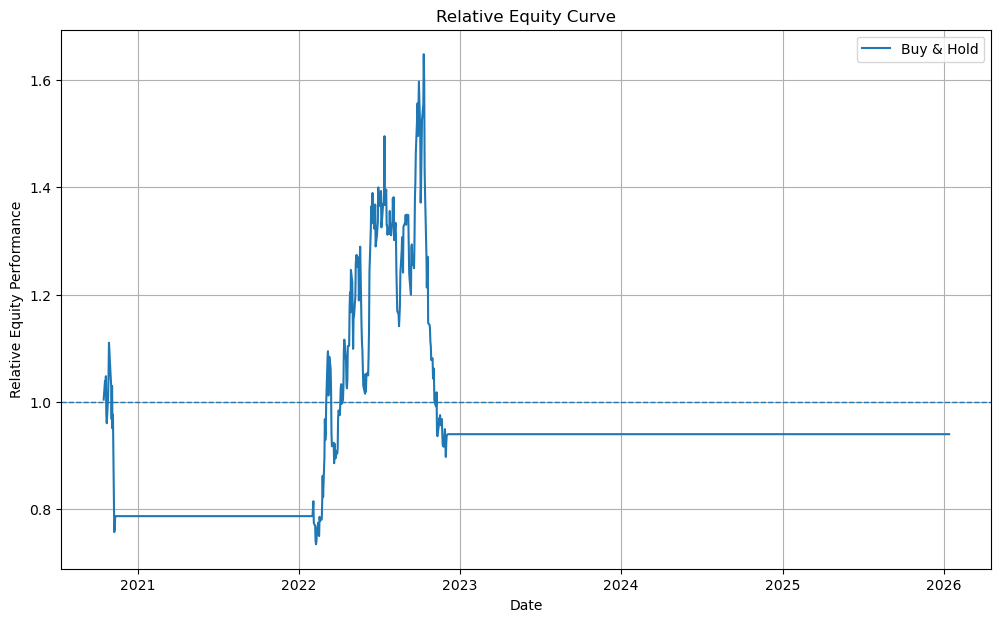

In [20]:
plt.figure(figsize = (12,7))
plt.plot(df.index, df['Relative_Equity'], label = 'Buy & Hold')
plt.axhline(1, linestyle = '--', linewidth = 1)
plt.title('Relative Equity Curve')
plt.ylabel('Relative Equity Performance')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

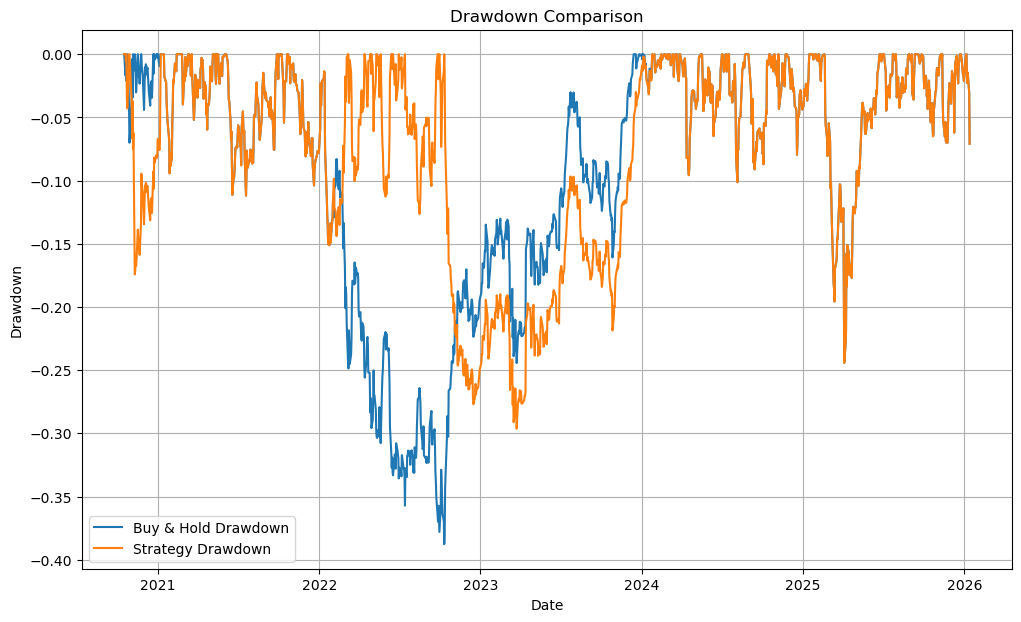

In [21]:
plt.figure(figsize = (12,7))
plt.plot(df.index, df['Draw_down_buy&hold'], label = 'Buy & Hold Drawdown')
plt.plot(df.index, df['Draw_down_Strategy'], label = 'Strategy Drawdown')
plt.title('Drawdown Comparison')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()